In [8]:
import json
import gzip
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.lines import Line2D
import matplotlib as mpl

In [9]:
# path_study_results = Path("/eos/user/l/lpauwels/Simulations/MomentumAcceptance/IntensityScan2/study_results")
path_study_results = Path("/Users/lisepauwels/sps_simulations/Studies/MomentumAcceptance/IntensityScan2/study_results")
name_files = [p.name for p in path_study_results.iterdir()]

In [10]:
def df_to_delta(df):
    slip_factor = 0.0017935055033301713
    f = 200_000_000
    return 1/slip_factor * df/f

In [11]:
sweep_per_turn = 1.0
data = {'linear' : {}, 'errors': {}}
for name_file in name_files:
    with gzip.open(path_study_results / name_file, "rt") as f:
        study_results = json.load(f)

    line_type = name_file.split("_")[1]
    chroma = float(name_file.split("_")[2].split(".json")[0])
    print(line_type, chroma)
    if chroma not in data[line_type]:
        data[line_type][chroma] = {}
    
    for plane in list(study_results.keys()):
        assert abs(study_results[plane]['sweep_per_turn']) == sweep_per_turn
        turns, counts = np.unique(study_results[plane]['at_turn'], return_counts=True)
        data[line_type][chroma][plane] = {'turns' : turns, 'counts' : counts}


errors 0.1
linear -0.2
errors -0.1
linear 0.3
errors -1.5
errors 1.5
linear 1.1
errors -0.7
linear 0.8
errors 0.7
linear -0.4
errors 1.3
linear -1.0
linear 0.5
linear -0.9
errors -1.3
linear -0.3
errors 0.0
errors -1.4
linear 0.2
errors 1.4
errors -0.6
linear 1.0
linear -0.5
linear 0.9
errors 0.6
linear -1.1
errors 1.2
errors -1.2
linear -0.8
linear 0.4
linear 1.5
errors -0.3
errors 0.3
linear -1.4
linear 0.1
errors 0.5
linear -0.6
linear 1.3
errors -0.5
linear 0.7
errors 0.8
errors -1.1
errors 1.1
errors -0.8
linear -1.2
errors -0.2
linear 1.4
linear -0.1
errors 0.2
linear -1.5
linear 0.0
linear -0.7
errors 0.4
errors -0.4
linear 1.2
errors -1.0
linear 0.6
errors 0.9
linear -1.3
errors -0.9
errors 1.0


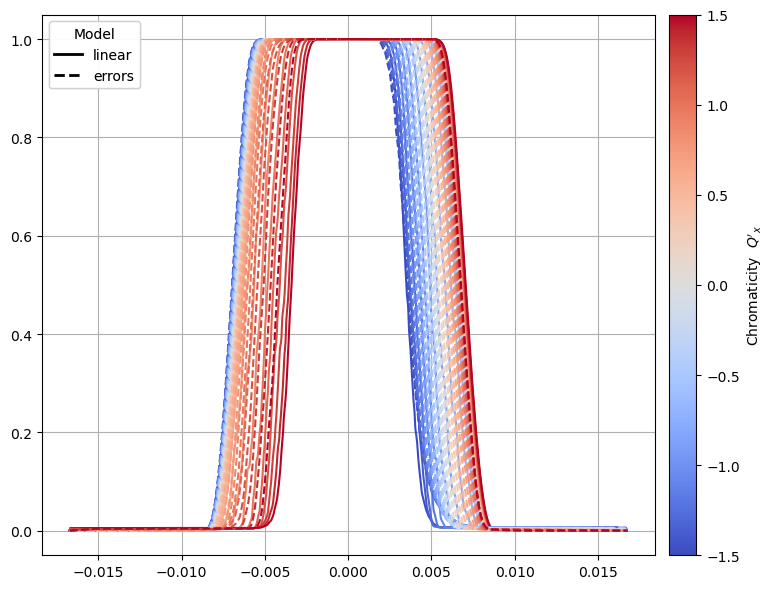

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
num_particles = 2000 * 500
line_styles = {'linear': '-', 'errors': '--'}

normalised_intensity = {}
# --- color map setup ---
all_chromas = sorted({ch for lt in data for ch in data[lt].keys()})
vmin, vmax = min(all_chromas), max(all_chromas)

cmap = colormaps['coolwarm']
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

def chroma_to_color(chroma):
    return cmap(norm(chroma))

# --- plotting ---
for line_type in ['linear', 'errors']:
    normalised_intensity[line_type] = {}
    for chroma in sorted(data[line_type].keys()):
        normalised_intensity[line_type][chroma] = {}
        for plane in ['DPpos', 'DPneg']:
            turns = data[line_type][chroma][plane]['turns']
            counts = data[line_type][chroma][plane]['counts']

            turns = np.concatenate(([0], turns))
            counts = np.concatenate(([0], counts))

            deltas = df_to_delta(turns * sweep_per_turn)
            if plane == 'DPneg':
                deltas = -deltas
            
            normalised_intensity[line_type][chroma][plane] = {'deltas': deltas, 'values': 1 - np.cumsum(counts) / num_particles}
            ax.plot(
                deltas,
                normalised_intensity[line_type][chroma][plane]['values'],
                color=chroma_to_color(chroma),
                linestyle=line_styles[line_type],
            )

# --- Legends ---
# 1) Model legend (line styles)
line_handles = [
    Line2D([0], [0], color='black', linestyle=line_styles[lt], linewidth=2, label=lt)
    for lt in line_styles
]
legend_model = ax.legend(handles=line_handles, title="Model", loc="upper left", frameon=True)
ax.add_artist(legend_model)

# 2) Chromaticity: use a colorbar (much better than 31 legend entries)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required by older mpl for colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Chromaticity  $Q'_x$")

ax.grid()
fig.tight_layout()
# plt.savefig('intensity_loss_vs_delta.png', dpi=300)


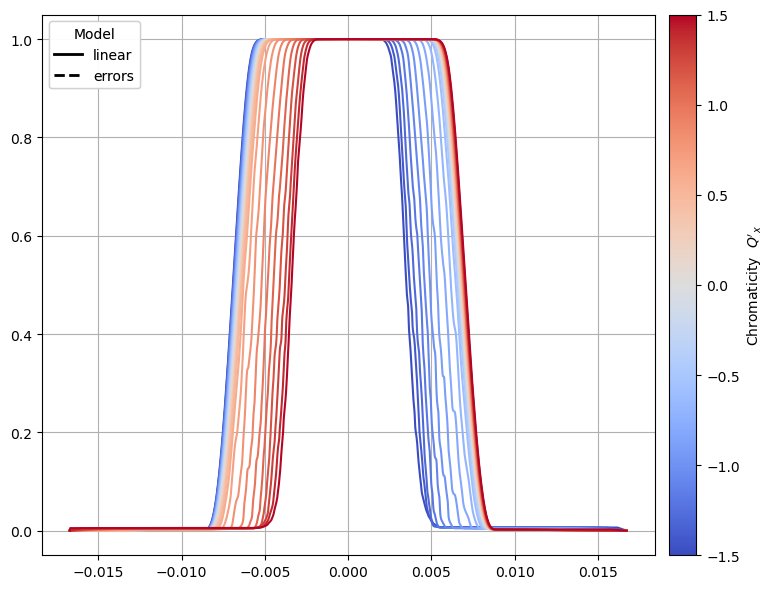

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
num_particles = 2000 * 500
line_styles = {'linear': '-', 'errors': '--'}

# --- color map setup ---
all_chromas = sorted({ch for lt in data for ch in data[lt].keys()})
vmin, vmax = min(all_chromas), max(all_chromas)

cmap = colormaps['coolwarm']
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

def chroma_to_color(chroma):
    return cmap(norm(chroma))

# --- plotting ---
for line_type in ['linear']:
    for chroma in sorted(data[line_type].keys()):
        for plane in ['DPpos', 'DPneg']:
            turns = data[line_type][chroma][plane]['turns']
            counts = data[line_type][chroma][plane]['counts']

            turns = np.concatenate(([0], turns))
            counts = np.concatenate(([0], counts))

            deltas = df_to_delta(turns * sweep_per_turn)
            if plane == 'DPneg':
                deltas = -deltas

            ax.plot(
                deltas,
                1 - np.cumsum(counts) / num_particles,
                color=chroma_to_color(chroma),
                linestyle=line_styles[line_type],
            )

# --- Legends ---
# 1) Model legend (line styles)
line_handles = [
    Line2D([0], [0], color='black', linestyle=line_styles[lt], linewidth=2, label=lt)
    for lt in line_styles
]
legend_model = ax.legend(handles=line_handles, title="Model", loc="upper left", frameon=True)
ax.add_artist(legend_model)

# 2) Chromaticity: use a colorbar (much better than 31 legend entries)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required by older mpl for colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Chromaticity  $Q'_x$")

ax.grid()
fig.tight_layout()
# plt.savefig('intensity_loss_vs_delta_linear.png', dpi=300)


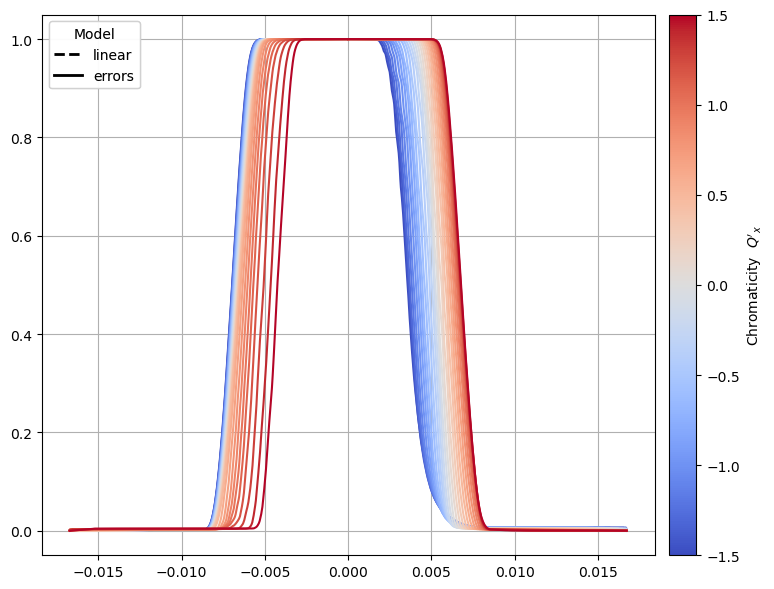

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
num_particles = 2000 * 500
line_styles = {'linear': '--', 'errors': '-'}

# --- color map setup ---
all_chromas = sorted({ch for lt in data for ch in data[lt].keys()})
vmin, vmax = min(all_chromas), max(all_chromas)

cmap = colormaps['coolwarm']
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

def chroma_to_color(chroma):
    return cmap(norm(chroma))

# --- plotting ---
for line_type in ['errors']:
    for chroma in sorted(data[line_type].keys()):
        for plane in ['DPpos', 'DPneg']:
            turns = data[line_type][chroma][plane]['turns']
            counts = data[line_type][chroma][plane]['counts']

            turns = np.concatenate(([0], turns))
            counts = np.concatenate(([0], counts))

            deltas = df_to_delta(turns * sweep_per_turn)
            if plane == 'DPneg':
                deltas = -deltas

            ax.plot(
                deltas,
                1 - np.cumsum(counts) / num_particles,
                color=chroma_to_color(chroma),
                linestyle=line_styles[line_type],
            )

# --- Legends ---
# 1) Model legend (line styles)
line_handles = [
    Line2D([0], [0], color='black', linestyle=line_styles[lt], linewidth=2, label=lt)
    for lt in line_styles
]
legend_model = ax.legend(handles=line_handles, title="Model", loc="upper left", frameon=True)
ax.add_artist(legend_model)

# 2) Chromaticity: use a colorbar (much better than 31 legend entries)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required by older mpl for colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Chromaticity  $Q'_x$")

ax.grid()
fig.tight_layout()
plt.savefig('intensity_loss_vs_delta_errors.png', dpi=300)


In [15]:
normalised_intensity

{'linear': {-1.5: {'DPpos': {'deltas': array([0.        , 0.00180931, 0.00182046, ..., 0.01616109, 0.01617781,
           0.01672702], shape=(1973,)),
    'values': array([1.      , 0.999999, 0.999998, ..., 0.00642 , 0.006419, 0.      ],
          shape=(1973,))},
   'DPneg': {'deltas': array([-0.        , -0.00451072, -0.00457763, ..., -0.00867853,
           -0.0086869 , -0.01672702], shape=(1365,)),
    'values': array([1.      , 0.999999, 0.999998, ..., 0.002578, 0.002577, 0.      ],
          shape=(1365,))}},
  -1.4: {'DPpos': {'deltas': array([0.        , 0.0020407 , 0.00205464, ..., 0.01558679, 0.01558958,
           0.01672702], shape=(1773,)),
    'values': array([1.      , 0.999999, 0.999998, ..., 0.00616 , 0.006159, 0.      ],
          shape=(1773,))},
   'DPneg': {'deltas': array([-0.        , -0.00457205, -0.00468078, ..., -0.00866181,
           -0.0086869 , -0.01672702], shape=(1368,)),
    'values': array([1.      , 0.999999, 0.999998, ..., 0.002548, 0.002547, 0.     

   line_type  chroma  delta_plus  delta_minus    center  acceptance
0     errors    -1.5    0.003571    -0.006972 -0.001700    0.010543
1     errors    -1.4    0.003621    -0.006960 -0.001670    0.010581
2     errors    -1.3    0.003700    -0.006945 -0.001622    0.010645
3     errors    -1.2    0.003815    -0.006931 -0.001558    0.010746
4     errors    -1.1    0.003939    -0.006914 -0.001488    0.010853
..       ...     ...         ...          ...       ...         ...
57    linear     1.1    0.006980    -0.004490  0.001245    0.011470
58    linear     1.2    0.007004    -0.004105  0.001449    0.011109
59    linear     1.3    0.007020    -0.003791  0.001615    0.010811
60    linear     1.4    0.007033    -0.003569  0.001732    0.010602
61    linear     1.5    0.007055    -0.003403  0.001826    0.010458

[62 rows x 6 columns]


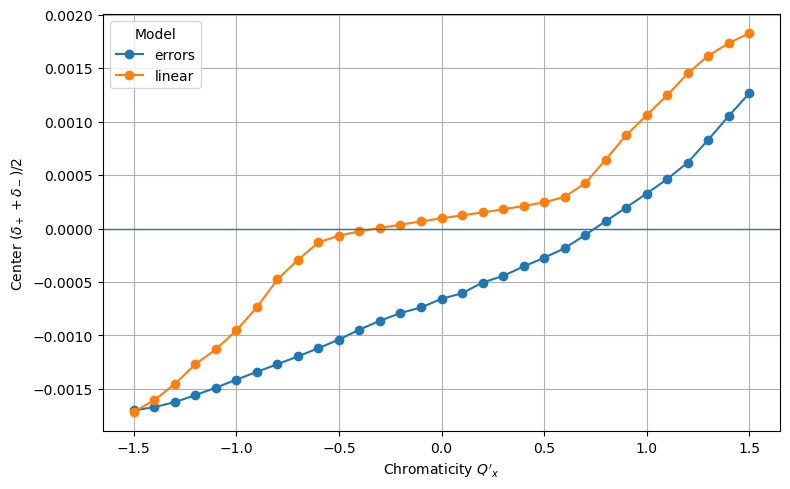

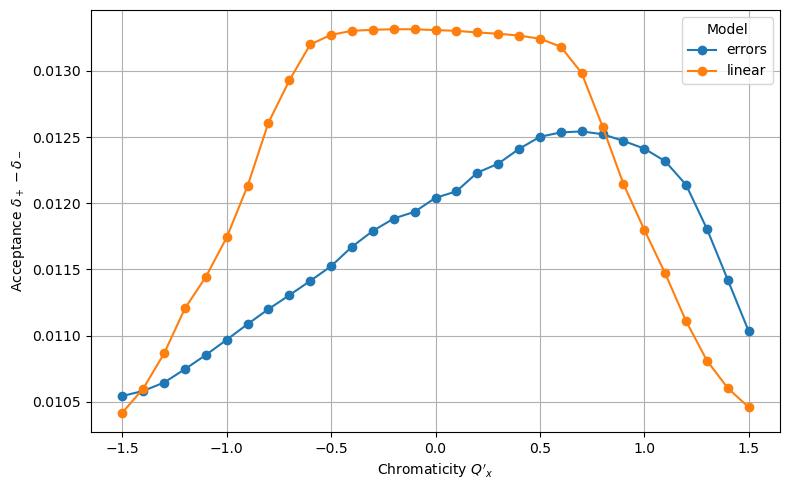

In [16]:
#!/usr/bin/env python3
"""
Compute midpoints (delta where normalised intensity reaches 0.5) for each
(line_type, chroma, plane) in `normalised_intensity`, then compute:

  center = (delta_plus + delta_minus)/2
  acceptance = delta_plus - delta_minus

Also makes a couple of simple plots vs chroma.

Expected dict structure:
normalised_intensity[line_type][chroma][plane] = {
    "deltas": np.ndarray,
    "values": np.ndarray,   # normalised intensity in [0, 1]
}
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

try:
    import pandas as pd
except ImportError:
    pd = None


def _as_arrays(deltas, values):
    x = np.asarray(deltas, dtype=float)
    y = np.asarray(values, dtype=float)
    if x.ndim != 1 or y.ndim != 1 or len(x) != len(y):
        raise ValueError("deltas and values must be 1D arrays of the same length")
    # sort by delta in case it's not sorted
    order = np.argsort(x)
    x = x[order]
    y = y[order]
    # drop NaNs
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m]


def delta_at_intensity(
    deltas,
    values,
    target=0.5,
    *,
    assume_monotonic=True,
):
    """
    Return delta where values cross `target`, using linear interpolation
    between the two nearest points straddling target.

    If no crossing exists, returns np.nan.
    If multiple crossings exist and assume_monotonic=False, returns the first crossing
    as delta increases (smallest delta at crossing).
    """
    x, y = _as_arrays(deltas, values)

    # Quick exit
    if len(x) < 2:
        return np.nan

    # If monotonic (typical survival/intensity curves), we just find the first straddle.
    # If not monotonic, we can still find any straddle(s).
    dy = y - target
    sign = np.sign(dy)

    # indices where sign changes or equals zero (exact hit)
    # exact hit
    exact = np.where(dy == 0)[0]
    if exact.size:
        return float(x[exact[0]])

    # straddle locations: dy[i] * dy[i+1] < 0
    straddle = np.where(dy[:-1] * dy[1:] < 0)[0]
    if straddle.size == 0:
        return np.nan

    i = int(straddle[0]) if (assume_monotonic or straddle.size == 1) else int(straddle[0])

    # Linear interpolation between (x[i], y[i]) and (x[i+1], y[i+1])
    x0, x1 = x[i], x[i + 1]
    y0, y1 = y[i], y[i + 1]
    if y1 == y0:
        return np.nan
    t = (target - y0) / (y1 - y0)
    return float(x0 + t * (x1 - x0))


def compute_midpoints_and_acceptance(normalised_intensity, target=0.5):
    """
    Returns nested dict results[line_type][chroma] = {
        "delta_plus": ...,
        "delta_minus": ...,
        "center": ...,
        "acceptance": ...
    }
    and (optionally) a pandas DataFrame if pandas is available.
    """
    results = {}

    for line_type, by_chroma in normalised_intensity.items():
        results[line_type] = {}
        for chroma, by_plane in by_chroma.items():
            # Find delta+ from DPpos, delta- from DPneg
            dp = {}
            for plane in ("DPpos", "DPneg"):
                if plane not in by_plane:
                    dp[plane] = np.nan
                    continue
                entry = by_plane[plane]
                deltas = entry.get("deltas", None)
                values = entry.get("values", None)
                if deltas is None or values is None:
                    dp[plane] = np.nan
                    continue
                dp[plane] = delta_at_intensity(deltas, values, target=target)

            delta_plus = dp["DPpos"]
            delta_minus = dp["DPneg"]

            # Your requested formulas (as written):
            center = np.nan
            acceptance = np.nan
            if np.isfinite(delta_plus) and np.isfinite(delta_minus):
                center = 0.5 * (delta_plus + delta_minus)
                acceptance = (delta_plus - delta_minus)

            results[line_type][chroma] = dict(
                delta_plus=delta_plus,
                delta_minus=delta_minus,
                center=center,
                acceptance=acceptance,
            )

    df = None
    if pd is not None:
        rows = []
        for line_type, by_chroma in results.items():
            for chroma, vals in by_chroma.items():
                rows.append(
                    dict(line_type=line_type, chroma=float(chroma), **vals)
                )
        df = pd.DataFrame(rows).sort_values(["line_type", "chroma"]).reset_index(drop=True)

    return results, df


def plot_vs_chroma(df_or_results):
    """
    If given a DataFrame (recommended), plots center and acceptance vs chroma for each line_type.
    """
    if pd is not None and hasattr(df_or_results, "columns"):
        df = df_or_results
        line_types = sorted(df["line_type"].unique())

        # Center
        fig1, ax1 = plt.subplots(figsize=(8, 5))
        for lt in line_types:
            d = df[df["line_type"] == lt]
            ax1.plot(d["chroma"], d["center"], marker="o", linestyle="-", label=lt)
        ax1.axhline(0.0, linewidth=1)
        ax1.grid(True)
        ax1.set_xlabel("Chromaticity $Q'_x$")
        ax1.set_ylabel(r"Center $(\delta_+ + \delta_-)/2$")
        ax1.legend(title="Model")
        fig1.tight_layout()

        # Acceptance
        fig2, ax2 = plt.subplots(figsize=(8, 5))
        for lt in line_types:
            d = df[df["line_type"] == lt]
            ax2.plot(d["chroma"], d["acceptance"], marker="o", linestyle="-", label=lt)
        ax2.grid(True)
        ax2.set_xlabel("Chromaticity $Q'_x$")
        ax2.set_ylabel(r"Acceptance $\delta_+ - \delta_-$")
        ax2.legend(title="Model")
        fig2.tight_layout()

        return (fig1, ax1), (fig2, ax2)

    else:
        raise ValueError("Pass the pandas DataFrame returned by compute_midpoints_and_acceptance.")


# -------------------- Example usage --------------------
if __name__ == "__main__":
    # You already have normalised_intensity in memory; just call:
    results, df = compute_midpoints_and_acceptance(normalised_intensity, target=0.5)

    if df is not None:
        #print(df.head())
        print(df)
        plot_vs_chroma(df)
        plt.show()
    else:
        # If pandas not installed, results is still usable
        print("pandas not installed; results is a nested dict.")
